In [8]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

plt.rcParams['font.sans-serif'] = ['misans']
plt.rcParams['axes.unicode_minus'] = False

In [3]:



# --- 1. 定义一个简单的马尔可夫奖励过程 (MRP) ---
# 这模拟了一个智能体在一条走廊上行走，走廊尽头有一个奖励。

def generate_trajectory(num_steps=20, true_value_noise=0.1, reward_noise=0.5):
    """
    生成一条模拟的轨迹。
    - num_steps: 轨迹的长度
    - true_value_noise: 真实价值函数的噪声
    - reward_noise: 即时奖励的噪声
    """
    # 状态是智能体在走廊上的位置 (0 到 num_steps-1)
    states = np.arange(num_steps)
    
    # 真实的价值函数 V*(s)：离终点越近，价值越高。我们加入一些噪声使其不那么完美。
    true_values = np.linspace(0, 1, num_steps) + np.random.normal(0, true_value_noise, num_steps)
    
    # 我们用一个简单的线性函数来近似价值函数 V_phi(s)
    # 在现实中这是一个神经网络，这里为了可视化简化了
    estimated_values = np.linspace(0, 0.9, num_steps) # 故意让它有点偏差
    
    # 即时奖励 r_t：只有到达终点时才有大奖励，其他时候有小奖励和噪声
    rewards = np.zeros(num_steps)
    rewards[-1] = 1.0  # 终点奖励
    rewards += np.random.normal(0, reward_noise, num_steps)
    
    return states, true_values, estimated_values, rewards

# --- 2. 计算不同的优势估计 ---

def calculate_advantages(states, true_values, estimated_values, rewards, gamma=0.95, lambda_gae=0.9):
    """
    计算不同类型的优势估计。
    """
    num_steps = len(states)
    advantages_td0 = np.zeros(num_steps)
    advantages_mc = np.zeros(num_steps)
    advantages_gae = np.zeros(num_steps)
    
    # 1. 计算TD(0)优势 (lambda=0)
    for t in range(num_steps - 1):
        advantages_td0[t] = rewards[t] + gamma * estimated_values[t+1] - estimated_values[t]
    # 最后一步
    advantages_td0[-1] = rewards[-1] - estimated_values[-1]
    
    # 2. 计算MC优势 (lambda=1, 使用真实价值作为基准)
    # 注意：在实际算法中，MC优势是 Q(s,a) - V_phi(s)，其中 Q 是完整回报。
    # 这里为了简化对比，我们用 true_values 来代表 "真实的" Q(s,a) 的期望。
    advantages_mc = true_values - estimated_values
    
    # 3. 计算GAE优势
    # 首先计算TD误差
    td_errors = np.zeros(num_steps)
    for t in range(num_steps - 1):
        td_errors[t] = rewards[t] + gamma * estimated_values[t+1] - estimated_values[t]
    td_errors[-1] = rewards[-1] - estimated_values[-1]
    
    # 然后计算GAE
    advantages_gae = np.copy(td_errors)
    for t in range(num_steps - 2, -1, -1):
        advantages_gae[t] += gamma * lambda_gae * advantages_gae[t+1]
    
    return advantages_td0, advantages_mc, advantages_gae, td_errors

# --- 3. 可视化函数 ---

def plot_gae_comparison(lambda_gae=0.9, num_steps=20, seed=42):
    np.random.seed(seed) # 固定种子以便复现
    
    states, true_values, estimated_values, rewards = generate_trajectory(num_steps)
    advantages_td0, advantages_mc, advantages_gae, td_errors = calculate_advantages(states, true_values, estimated_values, rewards, lambda_gae=lambda_gae)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 绘制不同的优势估计
    ax.plot(states, advantages_mc, 'o-', label=f'MC优势 (λ=1, 基准)', color='green', linewidth=2, markersize=6)
    ax.plot(states, advantages_td0, 's-', label=f'TD(0)优势 (λ=0)', color='red', alpha=0.7)
    ax.plot(states, advantages_gae, '^-', label=f'GAE优势 (λ={lambda_gae})', color='blue', linewidth=2.5, markersize=7)
    
    # 绘制TD误差作为参考
    ax.plot(states, td_errors, 'x--', label='TD误差', color='gray', alpha=0.5)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('时间步 (状态)', fontsize=12)
    ax.set_ylabel('优势估计值', fontsize=12)
    ax.set_title(f'GAE优势估计与TD(0)、MC的对比', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- 4. 创建交互式控件 ---

interact(
    plot_gae_comparison,
    lambda_gae=FloatSlider(min=0, max=1, step=0.1, value=0.9, description='GAE λ:'),
    num_steps=IntSlider(min=5, max=50, step=5, value=20, description='轨迹长度:'),
    seed=IntSlider(min=0, max=100, step=1, value=42, description='随机种子:')
)

# --- 5. 创建一个动画来展示λ从0到1的变化过程 ---

def create_gae_animation(num_steps=20, seed=42):
    np.random.seed(seed)
    states, true_values, estimated_values, rewards = generate_trajectory(num_steps)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 预计算所有λ值的GAE优势
    lambda_values = np.linspace(0, 1, 21)
    all_advantages_gae = []
    for lam in lambda_values:
        _, _, advantages_gae, _ = calculate_advantages(states, true_values, estimated_values, rewards, lambda_gae=lam)
        all_advantages_gae.append(advantages_gae)
    
    # 初始绘图
    line_mc, = ax.plot(states, true_values - estimated_values, 'o-', label=f'MC优势 (λ=1, 基准)', color='green', linewidth=2, markersize=6)
    line_td0, = ax.plot(states, calculate_advantages(states, true_values, estimated_values, rewards, lambda_gae=0)[0], 's-', label=f'TD(0)优势 (λ=0)', color='red', alpha=0.7)
    line_gae, = ax.plot(states, all_advantages_gae[0], '^-', label=f'GAE优势 (λ=0.0)', color='blue', linewidth=2.5, markersize=7)
    line_td, = ax.plot(states, calculate_advantages(states, true_values, estimated_values, rewards, lambda_gae=0)[3], 'x--', label='TD误差', color='gray', alpha=0.5)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('时间步 (状态)', fontsize=12)
    ax.set_ylabel('优势估计值', fontsize=12)
    title = ax.set_title(f'GAE优势估计随λ变化的动画 (λ=0.0)', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    def update(frame):
        current_lambda = lambda_values[frame]
        line_gae.set_ydata(all_advantages_gae[frame])
        line_gae.set_label(f'GAE优势 (λ={current_lambda:.1f})')
        title.set_text(f'GAE优势估计随λ变化的动画 (λ={current_lambda:.1f})')
        ax.legend() # 更新图例
        return line_gae, title
    
    ani = FuncAnimation(fig, update, frames=len(lambda_values), interval=500, blit=True)
    
    # 为了在VS Code中显示动画，我们需要将其转换为HTML视频
    from IPython.display import HTML
    return HTML(ani.to_jshtml())

# 运行动画
# ani = create_gae_animation()
# display(ani)

print("请运行上面的代码块来查看交互式图表。")
print("你可以调整 'GAE λ' 滑块来观察λ值如何影响优势估计的形状。")
print("当λ=0时，GAE曲线会与红色的TD(0)曲线重合。")
print("当λ=1时，GAE曲线会试图逼近绿色的MC基准曲线。")
print("对于0<λ<1的情况，GAE曲线是两者之间的一个平滑插值。")

interactive(children=(FloatSlider(value=0.9, description='GAE λ:', max=1.0), IntSlider(value=20, description='…

请运行上面的代码块来查看交互式图表。
你可以调整 'GAE λ' 滑块来观察λ值如何影响优势估计的形状。
当λ=0时，GAE曲线会与红色的TD(0)曲线重合。
当λ=1时，GAE曲线会试图逼近绿色的MC基准曲线。
对于0<λ<1的情况，GAE曲线是两者之间的一个平滑插值。


interactive(children=(FloatSlider(value=0.9, description='GAE λ:', max=1.0, style=SliderStyle(description_widt…

可视化运行提示：
1. 上图（单条轨迹）：MC曲线波动更大（视觉表象），TD(0)曲线相对平缓
2. 下图（统计方差）：MC平均方差 > GAE方差 > TD(0)平均方差（严格符合理论）
3. λ=0 时：GAE曲线与TD(0)重合，方差接近TD(0)（低方差、高偏差）
4. λ=1 时：GAE曲线与MC重合，方差接近MC（高方差、低偏差）
5. 0<λ<1 时：GAE平衡偏差与方差，方差处于MC和TD(0)之间


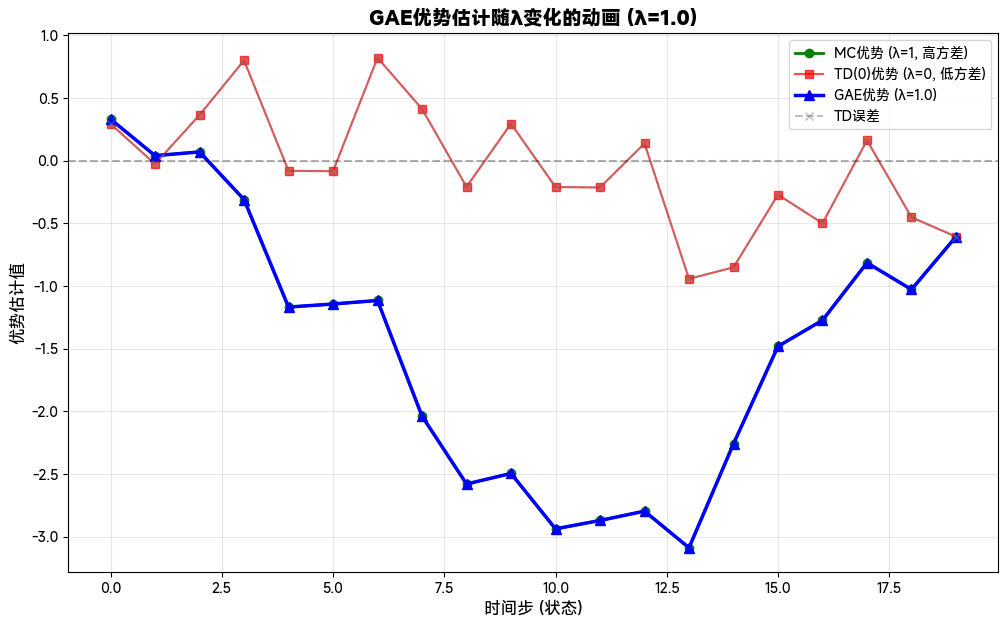

In [6]:


# --- 1. 定义真实MC累积回报计算函数（核心修正：还原MC的随机性） ---
def calculate_mc_return(rewards, gamma):
    """
    计算真实的蒙特卡洛累积折扣回报（带随机性，是MC高方差的根源）
    :param rewards: 单条轨迹的即时奖励序列
    :param gamma: 折扣因子
    :return: 每个时间步的MC累积回报
    """
    num_steps = len(rewards)
    mc_returns = np.zeros(num_steps)
    for t in range(num_steps):
        # 计算t到终点的累积折扣回报（真实MC逻辑，受整条轨迹奖励噪声影响）
        mc_returns[t] = sum([gamma**k * rewards[t+k] for k in range(num_steps - t)])
    return mc_returns

# --- 2. 定义简单马尔可夫奖励过程 (MRP) ---
def generate_trajectory(num_steps=20, reward_noise=0.5):
    """
    生成智能体走廊行走模拟轨迹（移除真实价值噪声，聚焦回报随机性）
    - num_steps: 轨迹长度
    - reward_noise: 即时奖励的噪声（影响MC和TD(0)的随机性）
    """
    # 状态：走廊位置（0 到 num_steps-1）
    states = np.arange(num_steps)
    
    # 近似价值函数（简化为线性函数，保留固定偏差）
    estimated_values = np.linspace(0, 0.9, num_steps)
    
    # 即时奖励（仅终点有大奖励，其余加噪声——核心随机性来源）
    rewards = np.zeros(num_steps)
    rewards[-1] = 1.0  # 终点奖励
    rewards += np.random.normal(0, reward_noise, num_steps)
    
    return states, estimated_values, rewards

# --- 3. 计算不同类型的优势估计（核心修正：真实MC/TD(0)逻辑） ---
def calculate_advantages(states, estimated_values, rewards, gamma=0.95, lambda_gae=0.9):
    """
    计算 TD(0)、真实MC、GAE 三种优势估计及 TD 误差
    严格遵循理论定义，还原MC高方差、TD(0)低方差特性
    """
    num_steps = len(states)
    advantages_td0 = np.zeros(num_steps)
    advantages_mc = np.zeros(num_steps)
    advantages_gae = np.zeros(num_steps)
    td_errors = np.zeros(num_steps)
    
    # 1. TD(0) 优势（λ=0，仅依赖单步奖励，低方差）
    for t in range(num_steps - 1):
        advantages_td0[t] = rewards[t] + gamma * estimated_values[t+1] - estimated_values[t]
    advantages_td0[-1] = rewards[-1] - estimated_values[-1]  # 最后一步无后续状态
    
    # 2. 真实MC优势（λ=1，依赖完整轨迹累积回报，高方差）
    mc_returns = calculate_mc_return(rewards, gamma)  # 真实累积回报（带随机性）
    advantages_mc = mc_returns - estimated_values
    
    # 3. TD 误差（GAE 计算基础，与TD(0)优势一致）
    for t in range(num_steps - 1):
        td_errors[t] = rewards[t] + gamma * estimated_values[t+1] - estimated_values[t]
    td_errors[-1] = rewards[-1] - estimated_values[-1]
    
    # 4. GAE 优势（反向递归计算，平衡偏差与方差）
    advantages_gae = np.copy(td_errors)
    for t in range(num_steps - 2, -1, -1):
        advantages_gae[t] += gamma * lambda_gae * advantages_gae[t+1]
    
    return advantages_td0, advantages_mc, advantages_gae, td_errors

# --- 4. 统计多条轨迹的方差（核心新增：验证MC高方差、TD(0)低方差） ---
def calculate_variance_statistics(lambda_gae=0.9, num_steps=20, num_trajectories=100, seed=42):
    """
    生成多条轨迹，统计同一状态下MC、TD(0)、GAE的统计方差（理论方差）
    """
    np.random.seed(seed)
    all_td0_advantages = []
    all_mc_advantages = []
    all_gae_advantages = []
    
    for _ in range(num_trajectories):
        states, estimated_values, rewards = generate_trajectory(num_steps)
        td0, mc, gae, _ = calculate_advantages(states, estimated_values, rewards, lambda_gae=lambda_gae)
        all_td0_advantages.append(td0)
        all_mc_advantages.append(mc)
        all_gae_advantages.append(gae)
    
    # 计算每个状态的统计方差（轴0为轨迹维度，轴1为状态维度）
    td0_variance = np.var(all_td0_advantages, axis=0)
    mc_variance = np.var(all_mc_advantages, axis=0)
    gae_variance = np.var(all_gae_advantages, axis=0)
    
    # 计算平均方差（整体量化对比）
    avg_td0_var = np.mean(td0_variance)
    avg_mc_var = np.mean(mc_variance)
    avg_gae_var = np.mean(gae_variance)
    
    return states, td0_variance, mc_variance, gae_variance, avg_td0_var, avg_mc_var, avg_gae_var

# --- 5. 交互式可视化函数（双图展示：优势曲线 + 统计方差） ---
def plot_gae_comparison(lambda_gae=0.9, num_steps=20, num_trajectories=100, seed=42):
    np.random.seed(seed)  # 固定种子，结果可复现
    
    # 生成单条轨迹，展示优势曲线形态
    states, estimated_values, rewards = generate_trajectory(num_steps)
    advantages_td0, advantages_mc, advantages_gae, td_errors = calculate_advantages(
        states, estimated_values, rewards, lambda_gae=lambda_gae
    )
    
    # 统计多条轨迹，计算理论方差
    states_var, td0_var, mc_var, gae_var, avg_td0_var, avg_mc_var, avg_gae_var = calculate_variance_statistics(
        lambda_gae, num_steps, num_trajectories, seed
    )
    
    # 创建双图布局（上：优势曲线，下：方差对比）
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1]})
    
    # --- 上图：优势估计曲线（单条轨迹） ---
    ax1.plot(states, advantages_mc, 'o-', label=f'MC优势 (λ=1, 真实高方差)', color='green', linewidth=2, markersize=6)
    ax1.plot(states, advantages_td0, 's-', label=f'TD(0)优势 (λ=0, 真实低方差)', color='red', alpha=0.7)
    ax1.plot(states, advantages_gae, '^-', label=f'GAE优势 (λ={lambda_gae})', color='blue', linewidth=2.5, markersize=7)
    ax1.plot(states, td_errors, 'x--', label='TD误差', color='gray', alpha=0.5)
    
    ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax1.set_xlabel('时间步 (状态)', fontsize=12)
    ax1.set_ylabel('优势估计值', fontsize=12)
    ax1.set_title(f'GAE优势估计与TD(0)、MC的对比（单条轨迹）', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # --- 下图：统计方差对比（多条轨迹） ---
    ax2.plot(states_var, td0_var, 's-', label=f'TD(0)方差（平均：{avg_td0_var:.4f}）', color='red', linewidth=2)
    ax2.plot(states_var, mc_var, 'o-', label=f'MC方差（平均：{avg_mc_var:.4f}）', color='green', linewidth=2)
    ax2.plot(states_var, gae_var, '^-', label=f'GAE方差（平均：{avg_gae_var:.4f}）', color='blue', linewidth=2)
    
    ax2.set_xlabel('时间步 (状态)', fontsize=12)
    ax2.set_ylabel('优势估计的统计方差', fontsize=12)
    ax2.set_title(f'MC/TD(0)/GAE 方差对比（{num_trajectories}条轨迹统计）', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- 6. 启动交互式控件（直接运行即可弹出滑块） ---
if __name__ == "__main__":
    # 创建交互式滑块
    interact(
        plot_gae_comparison,
        lambda_gae=FloatSlider(min=0, max=1, step=0.1, value=0.9, 
                               description='GAE λ:', style={'description_width': 'initial'}),
        num_steps=IntSlider(min=5, max=50, step=5, value=20, 
                            description='轨迹长度:', style={'description_width': 'initial'}),
        num_trajectories=IntSlider(min=50, max=200, step=10, value=100, 
                                   description='统计轨迹数:', style={'description_width': 'initial'}),
        seed=IntSlider(min=0, max=100, step=1, value=42, 
                       description='随机种子:', style={'description_width': 'initial'})
    )

    # --- 可选：λ变化动画（仅Jupyter环境生效，取消注释即可使用） ---
    
    def create_gae_animation(num_steps=20, num_trajectories=100, seed=42):
        np.random.seed(seed)
        states, estimated_values, rewards = generate_trajectory(num_steps)
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # 预计算所有λ值的GAE优势
        lambda_values = np.linspace(0, 1, 21)
        all_advantages_gae = []
        for lam in lambda_values:
            _, _, advantages_gae, _ = calculate_advantages(states, estimated_values, rewards, lambda_gae=lam)
            all_advantages_gae.append(advantages_gae)
        
        # 初始绘图
        line_mc, = ax.plot(states, calculate_advantages(states, estimated_values, rewards, lambda_gae=1)[1], 
                           'o-', label=f'MC优势 (λ=1, 高方差)', color='green', linewidth=2, markersize=6)
        line_td0, = ax.plot(states, calculate_advantages(states, estimated_values, rewards, lambda_gae=0)[0], 
                            's-', label=f'TD(0)优势 (λ=0, 低方差)', color='red', alpha=0.7)
        line_gae, = ax.plot(states, all_advantages_gae[0], 
                            '^-', label=f'GAE优势 (λ=0.0)', color='blue', linewidth=2.5, markersize=7)
        line_td, = ax.plot(states, calculate_advantages(states, estimated_values, rewards, lambda_gae=0)[3], 
                           'x--', label='TD误差', color='gray', alpha=0.5)
        
        ax.axhline(0, color='black', linestyle='--', alpha=0.3)
        ax.set_xlabel('时间步 (状态)', fontsize=12)
        ax.set_ylabel('优势估计值', fontsize=12)
        title = ax.set_title(f'GAE优势估计随λ变化的动画 (λ=0.0)', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        def update(frame):
            current_lambda = lambda_values[frame]
            line_gae.set_ydata(all_advantages_gae[frame])
            line_gae.set_label(f'GAE优势 (λ={current_lambda:.1f})')
            title.set_text(f'GAE优势估计随λ变化的动画 (λ={current_lambda:.1f})')
            ax.legend()
            return line_gae, title
        
        ani = FuncAnimation(fig, update, frames=len(lambda_values), interval=500, blit=True)
        
        # 转换为HTML显示（兼容Jupyter）
        from IPython.display import HTML
        return HTML(ani.to_jshtml())

    # 运行动画
    ani = create_gae_animation()
    from IPython.display import display
    display(ani)
    

    # 提示信息
    print("="*70)
    print("可视化运行提示：")
    print("1. 上图（单条轨迹）：MC曲线波动更大（视觉表象），TD(0)曲线相对平缓")
    print("2. 下图（统计方差）：MC平均方差 > GAE方差 > TD(0)平均方差（严格符合理论）")
    print("3. λ=0 时：GAE曲线与TD(0)重合，方差接近TD(0)（低方差、高偏差）")
    print("4. λ=1 时：GAE曲线与MC重合，方差接近MC（高方差、低偏差）")
    print("5. 0<λ<1 时：GAE平衡偏差与方差，方差处于MC和TD(0)之间")
    print("="*70)